

# Yelp Reviews Sentiment
Could a model tell only by looking at the text of a review, if its positive, negative or neutral? This is the question we try to answer with this project. This notebook should give you a brief idea on how we tried to solve this task. How did we preprocessed the data, what model did we use and how did we tune the hyperparameter.


## Importing Modules

In [1]:
!pip install fasttext
from google.colab import drive
import keras
import joblib
import numpy as np 
import pandas as pd
import fasttext.util
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from typing import List, Dict, Union
from gensim.utils import simple_preprocess
from keras.preprocessing.text import Tokenizer
from gensim.parsing.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

     |████████████████████████████████| 71kB 3.1MB/s 
ERROR: Operation cancelled by user


Using TensorFlow backend.


ModuleNotFoundError: ignored

## Data Loading
The data is stored in a huge >6GB JSON file. The first step is to optimize the data so it fits into the RAM of a working environment like for example Google Colab.
We therefore drop all columns except for stars, text and date and optimize the datatypes

**Note:** To run this code you should make sure to have enough RAM 

In [ ]:
path = 'data/'

def prep(x: pd.DataFrame) -> pd.DataFrame:
  x['text'] = x['text'].astype('string')
  x['stars'] = x['stars'].astype('category')
  return x[['stars', 'text', 'date']]

json_filename = "yelp_academic_dataset_review.json"

df: pd.DataFrame = pd.read_json(path + json_filename, lines=True, chunksize=8192)
preped_chunks: List[pd.DataFrame] = []

for chunk in df:
    preped_chunks.append(prep(chunk))

data = pd.concat(preped_chunks)

## Subsampling
Now that we have the optimized.pickle file we can take a subsample of 400,000 reviews and split it  in train, validation and test data. The train set will have balanced classe, the class distribution in validation and test set will follow the original distribution. Further are we going to categorize 5 and 4 stars as `positive`, 3 as `neutral` and 2 and 1 as `negative`.


In [ ]:

def stars_to_category(stars: int) -> int:
    """Converts stars of 1 to 5 to categories negative (-1), neutral (0), positive (1)"""
    return -1 if stars <= 2 else 0 if stars == 3 else 1

total_num_samples: int = 400_000
train_ratio: float = 0.75
validation_ratio: float = 0.15
test_ratio: float = 0.1

if train_ratio + validation_ratio + test_ratio != 1:
    raise ValueError("Train-, Validation- and Testratio have to sum to 1!")

try: data
except NameError: data = None

if data is None:
  path_to_pickle = path + 'reviews_optimized.pickle'
  df = pd.read_pickle(path_to_pickle)
else:
  df = data

x_train, x_test, y_train, y_test = train_test_split(
    df.drop('stars', axis=1),
    df['stars'],
    test_size=1 - train_ratio
)

# Map stars to categories: positive, neutral, negative
y_train = y_train.apply(stars_to_category)
y_test = y_test.apply(stars_to_category)

# Split the (too) large test set into validation and test
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_ratio / (test_ratio + validation_ratio)
)

# Group by stars. Subsample an equal number of samples from each group
groups = x_train.groupby(y_train)
samples = []

for _, group in groups:
    samples.append(group.sample(int(total_num_samples * train_ratio // 3)))

x_train = pd.concat(samples)
y_train = y_train[x_train.index]

# Randomly sumbsample validation data
x_val = x_val.sample(int(total_num_samples * validation_ratio))
y_val = y_val[x_val.index]

# Randomly sumbsample test data
x_test = x_test.sample(int(total_num_samples * test_ratio))
y_test = y_test[x_test.index]

print("Successfully split data! Train/Validation/Test-Shapes are:")
for split in [x_train, x_val, x_test]:
    print(split.shape)

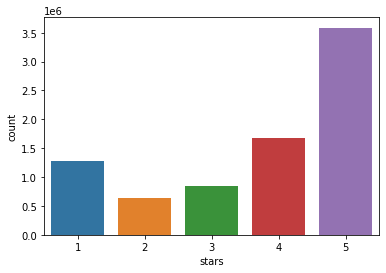

In [ ]:
sns.countplot(x = df['stars'])


## Create Embeddings
To understand the text, it is necessary to classify and represent the text as a vector. We use the open source library fasttext from Facebook where every word is represented as a 300 dimensional vector.
The whole fasttext file with the pre-trained vectors is about 7GB big. So we build a matrix with only the vectors that represent the words in our subsample.
First we tokenize alle words in our training data and then get the vectors affiliated to this word.


In [ ]:
ft = fasttext.load_model(path + 'cc.en.300.bin')
ps = PorterStemmer()

tokens_xtrain = [simple_preprocess(line, deacc=True) for line in x_train['text']]

def stem(list_of_words):
  return [ps.stem(word.encode("ascii", errors="ignore").decode().strip()) for word in list_of_words]

with mp.Pool(mp.cpu_count()) as p:
  result = p.map(stem, tokens_xtrain)

tok = Tokenizer()
tok.fit_on_texts(result)
tokens_xtrain = tok.texts_to_sequences(result)

embedding_matrix = np.zeros((len(tok.word_index) + 1, 300))

for word, index in tok.word_index.items():
  embedding_matrix[index] = ft.get_word_vector(word)

In [ ]:
print(embedding_matrix.shape)
print(embedding_matrix[12])

(72078, 300)
[ 1.96468800e-01 -3.13726254e-02 -2.41170809e-01  4.46168408e-02
  4.54317965e-02 -4.03451137e-02  6.98714107e-02  7.12221116e-02
 -1.38014197e-01 -1.26375509e-02  1.22694552e-01 -2.17745692e-01
 -3.15024219e-02 -1.51289761e-01 -1.09417945e-01  3.88599038e-01
 -1.07319430e-01  5.84536344e-02 -1.14523575e-01 -2.02204287e-01
  7.52315670e-02  6.06266260e-02  4.30230238e-02 -1.19575836e-01
  3.14096272e-01 -1.58089444e-01 -1.76111087e-01 -5.33110090e-03
 -8.54974091e-02  5.84432781e-01 -4.80109490e-02 -1.62025675e-01
 -1.20477319e-01 -5.20017594e-02  1.65450007e-01 -2.90732354e-01
 -8.84420052e-02 -6.55105710e-02 -5.62775657e-02 -5.85129820e-02
 -2.53408961e-02  9.65959877e-02 -9.76902843e-02  6.49419785e-01
 -2.33020321e-01 -1.13205076e-03  3.47818322e-02  6.07724972e-02
 -2.20823228e-01 -1.25138834e-01  8.31027776e-02  3.24304737e-02
 -1.24179207e-01  1.86581071e-02 -2.04450712e-01 -2.94653684e-01
 -2.68991709e-01  3.04282993e-01 -2.51636744e-01  1.49952084e-01
 -9.72808078

## Modelling

In [ ]:
x_train = tok.texts_to_sequences(x_train['text'])
x_val = tok.texts_to_sequences(x_val['text'])
x_test = tok.texts_to_sequences(x_test['text'])

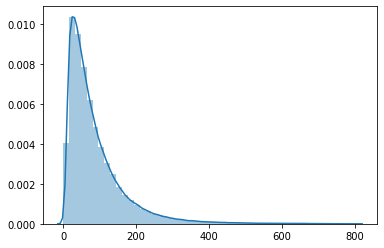

In [ ]:
sns.distplot([len(x) for x in x_train])

You can clearly tell that most reviews have way less characters than 400. To minimize the number of zero representations we decide to take a 90th percentile crop if the sequences. The label will be One-Hot encoded so we get a 3 dimensional vector where the given category is represented as a 1 and the others as 0.

In [ ]:
MAX_INPUT_LENGTH = int(np.round(np.percentile([len(x) for x in x_train], 90)))  # 90th percentile crop

x_train = pad_sequences(x_train, MAX_INPUT_LENGTH)
x_val = pad_sequences(x_val, MAX_INPUT_LENGTH)
x_test = pad_sequences(x_test, MAX_INPUT_LENGTH)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_test = ohe.fit_transform(y_test.values.reshape(-1, 1))
y_val = ohe.fit_transform(y_val.values.reshape(-1, 1))

In [ ]:
BATCH_SIZE = 1024
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5 
N_EPOCHS = 10

try: embedding_matrix
except NameError: embedding_matrix = None

if embedding_matrix is None:
  path_to_pickle = path + 'embedding_matrix.pickle'
  embedding_matrix = pd.read_pickle(path_to_pickle)

model = keras.Sequential([
        keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, weights=[embedding_matrix], output_dim=300,
                               trainable=False, input_length=max_input_length),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPool1D(),
        keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu'),
        keras.layers.MaxPool1D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])
print(model.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 183, 300)          21623400  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 181, 64)           57664     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 90, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 87, 128)           32896     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 43, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5504)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5504)             

In [ ]:
model.compile('adam', keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 60000 samples
Epoch 1/10
300000/300000 [==============================] - 22s 75us/step - loss: 0.6969 - accuracy: 0.6902 - val_loss: 0.5134 - val_accuracy: 0.7969
Epoch 2/10
300000/300000 [==============================] - 21s 69us/step - loss: 0.5718 - accuracy: 0.7594 - val_loss: 0.5595 - val_accuracy: 0.7721
Epoch 3/10
300000/300000 [==============================] - 20s 68us/step - loss: 0.5182 - accuracy: 0.7836 - val_loss: 0.5836 - val_accuracy: 0.7700
Epoch 4/10
300000/300000 [==============================] - 20s 68us/step - loss: 0.4644 - accuracy: 0.8080 - val_loss: 0.5459 - val_accuracy: 0.7904
Epoch 5/10
300000/300000 [==============================] - 21s 68us/step - loss: 0.4088 - accuracy: 0.8337 - val_loss: 0.6260 - val_accuracy: 0.7708
Epoch 6/10
300000/300000 [==============================] - 21s 68us/step - loss: 0.3507 - accuracy: 0.8594 - val_loss: 0.7531 - val_accuracy: 0.7454
Epoch 7/10
300000/300000 [=======================

Text(0, 0.5, 'Accuracy')

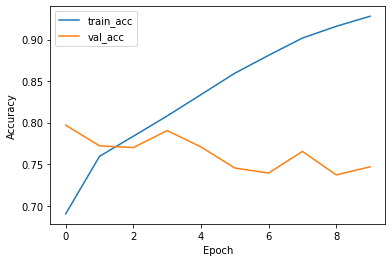

In [ ]:
pd.DataFrame({
    'train_acc': model.history.history['accuracy'],
    'val_acc': model.history.history['val_accuracy']
    }).plot()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
print("\n" + classification_report(np.argmax(y_val.toarray(), axis=1), model.predict_classes(x_val)))


              precision    recall  f1-score   support

           0       0.78      0.75      0.77     14333
           1       0.28      0.64      0.39      6238
           2       0.95      0.76      0.84     39429

    accuracy                           0.75     60000
   macro avg       0.67      0.72      0.67     60000
weighted avg       0.84      0.75      0.78     60000

